# WIP: Books Crossing Dataset

Books crossing data set contains ratings for books by users. This data set contains three files:
    - BX-Books.csv: List of books along with meta data
    - BX-Book-Ratings.csv: The ratings for all the books at a user level
    - BX-Users.csv: Meta data on the users

Data can be found [here](http://www2.informatik.uni-freiburg.de/~cziegler/BX/)

This notebook aims to build a recommendation engine to recommend to new books to users and is based of [this](https://towardsdatascience.com/how-did-we-build-book-recommender-systems-in-an-hour-the-fundamentals-dfee054f978e) post, with some improvements.

## Reading in the Data

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline  

When reading in the data for books, there may be lines where there are more columns than present in the header (Each book also has image URLs linking the cover of the book, a column may have more than one URL), this will throw an error. Setting `error_bad_lines` to false will skip these lines and will not be part of the data frame. 

In [21]:
# Read in the data
books = pd.read_csv('..\Data\BX-Books.csv', sep=';', header=0, encoding="latin-1", error_bad_lines=False) # sorry, I'm on Windows :(

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
c:\users\harpal\envs\datascience64\lib\site-packages\IPython\core\interact

Looks like only 4 lines were skipped, this should not greatly impact the model

In [22]:
ratings = pd.read_csv('..\Data\BX-Book-Ratings.csv', sep=';', header=0, encoding="latin-1")

In [23]:
users = pd.read_csv('..\Data\BX-Users.csv', sep=';', encoding="latin-1")

### Books Data

In [24]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


Let's see what the data looks like for our datasets

In [25]:
books.describe()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
count,271360,271360,271359,271360,271358,271360,271360,271357
unique,271360,242135,102023,202,16807,271044,271044,271041
top,0740734954,Selected Poems,Agatha Christie,2002,Harlequin,http://images.amazon.com/images/P/074343627X.0...,http://images.amazon.com/images/P/044022165X.0...,http://images.amazon.com/images/P/039552105X.0...
freq,1,27,632,13903,7535,2,2,2


We have 271369 unique ISBNs and therefore 271360 unique books. Is this the case with the actual shape of the data frame?

In [26]:
books.shape

(271360, 8)

Yes it is. By the looks of it we also have a book without an author where the count is 271359 and it should be 271360.

In [27]:
# Get the row with no book author
books[books['Book-Author'].isna()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...


Data is also rather messy, there are some rows where the `Book-Author` and `Year-Of-Publication` have been switched

In [28]:
books[books['Year-Of-Publication'] == 'DK Publishing Inc']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


In [29]:
# Swap the values around
books.at[209538, 'Year-Of-Publication'] = 2000
books.at[221678, 'Year-Of-Publication'] = 2000
books.at[209538, 'Book-Author'] = 'DK Publishing Inc'
books.at[221678, 'Book-Author'] = 'DK Publishing Inc'

In [30]:
books[books['Year-Of-Publication'] == 'Gallimard']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN


In [31]:
# Swap the values around
books.at[220731, 'Year-Of-Publication'] = 2003
books.at[220731, 'Book-Author'] = 'Gallimard'

In [32]:
# Make the year-of-publication an int type
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002183BE1C128>]], dtype=object)

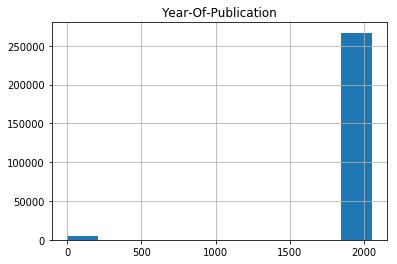

In [33]:
# Plot a hist of the year-of-publication
books.hist(column=['Year-Of-Publication'])

We must have rows where the `Year-Of-Publication` is set to zero

In [34]:
books[books['Year-Of-Publication'] < 500].shape

(4618, 8)

4618 rows in fact

In [35]:
books[books['Year-Of-Publication'] < 500].head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
176,3150000335,Kabale Und Liebe,Schiller,0,"Philipp Reclam, Jun Verlag GmbH",http://images.amazon.com/images/P/3150000335.0...,http://images.amazon.com/images/P/3150000335.0...,http://images.amazon.com/images/P/3150000335.0...
188,342311360X,Die Liebe in Den Zelten,Gabriel Garcia Marquez,0,Deutscher Taschenbuch Verlag (DTV),http://images.amazon.com/images/P/342311360X.0...,http://images.amazon.com/images/P/342311360X.0...,http://images.amazon.com/images/P/342311360X.0...
288,0571197639,Poisonwood Bible Edition Uk,Barbara Kingsolver,0,Faber Faber Inc,http://images.amazon.com/images/P/0571197639.0...,http://images.amazon.com/images/P/0571197639.0...,http://images.amazon.com/images/P/0571197639.0...
351,3596214629,"Herr Der Fliegen (Fiction, Poetry and Drama)",Golding,0,Fischer Taschenbuch Verlag GmbH,http://images.amazon.com/images/P/3596214629.0...,http://images.amazon.com/images/P/3596214629.0...,http://images.amazon.com/images/P/3596214629.0...
542,8845229041,Biblioteca Universale Rizzoli: Sulla Sponda De...,P Coelho,0,Fabbri - RCS Libri,http://images.amazon.com/images/P/8845229041.0...,http://images.amazon.com/images/P/8845229041.0...,http://images.amazon.com/images/P/8845229041.0...


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002182BE76A20>]], dtype=object)

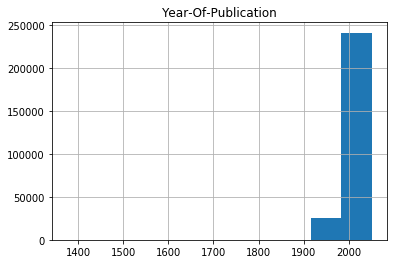

In [36]:
books[books['Year-Of-Publication'] > 0].hist(column=['Year-Of-Publication'])

We clearly have books pre 1900 which only occur a few times. The vast majority of books are post 1900.

In [37]:
books[(books['Year-Of-Publication'] > 0) & (books['Year-Of-Publication'] < 1900)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
171817,0781228956,"Complete Works 10 Volumes [2,6,7,8,9] (Notable...",Benjamin Franklin,1806,Reprint Services Corp,http://images.amazon.com/images/P/0781228956.0...,http://images.amazon.com/images/P/0781228956.0...,http://images.amazon.com/images/P/0781228956.0...
227531,9643112136,Dalan-i bihisht (Dastan-i Irani),Nazi Safavi,1378,Intisharat-i Quqnus,http://images.amazon.com/images/P/9643112136.0...,http://images.amazon.com/images/P/9643112136.0...,http://images.amazon.com/images/P/9643112136.0...
245607,0781268001,"Hugh Wynne, Free Quaker (2 Volumes (BCL1-PS Am...",Silas Weir Mitchell,1897,Reprint Services Corp,http://images.amazon.com/images/P/0781268001.0...,http://images.amazon.com/images/P/0781268001.0...,http://images.amazon.com/images/P/0781268001.0...
253750,964442011X,Tasht-i khun,IsmaÂ°il Fasih,1376,Nashr-i Alburz,http://images.amazon.com/images/P/964442011X.0...,http://images.amazon.com/images/P/964442011X.0...,http://images.amazon.com/images/P/964442011X.0...


What about the authors. What are the top 10 most common authors?

In [38]:
books['Book-Author'].value_counts().head(n=10)

Agatha Christie        632
William Shakespeare    567
Stephen King           524
Ann M. Martin          423
Carolyn Keene          373
Francine Pascal        372
Isaac Asimov           330
Nora Roberts           315
Barbara Cartland       307
Charles Dickens        302
Name: Book-Author, dtype: int64

### Ratings Data

The ratings data lists ratings for each book by a given user.

In [39]:
ratings.shape

(1149780, 3)

We have over 1 million ratings

In [40]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [41]:
ratings.describe()

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


The ratings range from 0 - 10, let's plot this as a bar chart

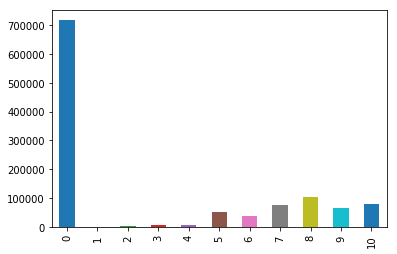

In [42]:
ratings['Book-Rating'].value_counts().sort_index().plot(kind='bar')

The ratings are heavily skewed towards a 0 rating!

Let's have a look at the histogram of average rating by users

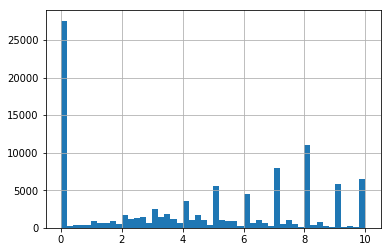

In [43]:
ratings.groupby(by=['User-ID'])['Book-Rating'].mean().hist(bins=50)

Some very cynical readers out there! Interestingly, there are also peaks at whole numbers e.g. 4, 5, 6 etc... I'm guessing these peaks are due to a low number of ratings for given users

### Users Data

In [44]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [45]:
users.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


Pandas has made `User-ID` and `int` type let's make it a `str` type

In [46]:
users['User-ID'] = users['User-ID'].astype(str)

In [47]:
users.shape

(278858, 3)

We have 278858 users. Are they all unique?

In [48]:
users.describe(include=['object'])

,User-ID,Location
count,278858,278858
unique,278858,57339
top,276271,"london, england, united kingdom"
freq,1,2506


Yup, all unique!

What's the age distribution of our users?

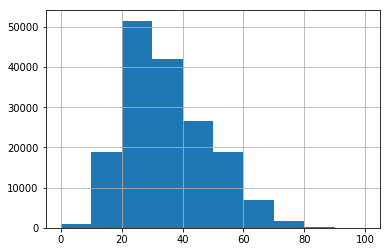

In [49]:
users['Age'].hist(bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

Most of the users are aged between 20 - 40

Are there any users older than 100?

In [50]:
users[users['Age'] > 100].shape

(366, 3)

366 users older than 100... not sure if these are genuine

## Recommendations based on correlations

With the quickly exploratory analysis complete. Let’s look at building recommendations. To get recommendations based on correlations (Pearson R) we need to calculate a couple of metrics: the average rating and number of ratings per book.

In [51]:
average_rating = pd.DataFrame(ratings.groupby(by=['ISBN'])['Book-Rating'].mean())
average_rating['Rating-Count'] = pd.DataFrame(ratings.groupby(by=['ISBN'])['Book-Rating'].count())
average_rating.sort_values('Rating-Count', ascending=False).head()

,Book-Rating,Rating-Count
ISBN,,
0971880107,1.019584,2502
0316666343,4.468726,1295
0385504209,4.652322,883
0060928336,3.448087,732
0312195516,4.334716,723


The book with the most ratings it not rated very well... Let's look at the `average_rating` sorted by `Book-Rating`

In [52]:
average_rating.sort_values('Book-Rating', ascending=False).head(n=20)

,Book-Rating,Rating-Count
ISBN,,
0874477050,10.0,1
561002010,10.0,1
0590939874,10.0,1
1570761914,10.0,1
56500624X,10.0,1
157076154X,10.0,1
1570761175,10.0,1
0373510365,10.0,1
0393092526,10.0,1


Okay, we have a problem here. The top rated books only have a single rating. If we made recommendations based on these ratings we may get some very strange results. To circumvent this we should filter out books with say less than 100 ratings. Another similar issue may occur where users have only rated a single book, so another threshold should be applied here. We will filter out users with less that 200 ratings.

In [53]:
user_counts = ratings['User-ID'].value_counts()
ratings_filtered = ratings[ratings['User-ID'].isin(user_counts[user_counts >= 200].index)] # Filters out users with less than 200 ratings

In [54]:
book_counts = ratings_filtered['ISBN'].value_counts()
ratings_filtered = ratings_filtered[ratings_filtered['ISBN'].isin(book_counts[book_counts >= 100].index)] # Filters out book with less than 100 ratings

In [55]:
ratings_filtered.shape

(13793, 3)

### Ratings Matrix

Convert the `ratings_filtered` table into a 2D matrix

In [56]:
ratings_pivot = ratings_filtered.pivot(index='User-ID', columns='ISBN')['Book-Rating']
ratings_pivot.head()

ISBN,0060502258,0060928336,0060930535,0060934417,0060976845,0060987103,0061009059,006101351X,014028009X,0140293248,...,067976402X,0679781587,068484477X,0743418174,0786868716,080410526X,0804106304,080410753X,0971880107,1400034779
User-ID,,,,,,,,,,,,,,,,,,,,,
254,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,0.0,8.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN
2977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3363,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN


In [57]:
ratings_pivot.shape

(857, 100)

In [58]:
user_id = ratings_pivot.index
isbn = ratings_pivot.columns

Let's find out what books are correlated with the 2nd most rated book

In [59]:
second_most_rated = '0316666343'
books[books['ISBN'] == second_most_rated]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
408,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...


The second most rated book is the `The lovely bones` novel by Alice Sebold.

In [60]:
lovely_bones_ratings = ratings_pivot[second_most_rated]

In [61]:
similar_to_bones = ratings_pivot.corrwith(lovely_bones_ratings)

In [62]:
corr_lovely_bones = pd.DataFrame(similar_to_bones, columns=['pearson_r'])
corr_lovely_bones.dropna(inplace=True) # Drop any NA's where there were no ratings for calculation

In [63]:
corr_summary = corr_lovely_bones.join(average_rating['Rating-Count']) # Join on the average ratings by ISBN
corr_sorted_top_n = corr_summary.sort_values('pearson_r', ascending=False).head(10) # Top 10 correlated ratings
corr_sorted_top_n

,pearson_r,Rating-Count
ISBN,,
0316666343,1.000000,1295
0440211263,0.537130,229
0316601950,0.434248,568
0446610038,0.429712,391
0446672211,0.421478,585
0446601241,0.372135,229
0385265700,0.351635,319
0345342968,0.316922,321
0060930535,0.309860,494


Above are the top 10 related books, as a sanity check, the book scores a perfect 1 when compared with itself (w00p!). What are the related books:

In [64]:
books[books['ISBN'].isin(corr_sorted_top_n.index)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
408,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...
706,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998,Warner Books,http://images.amazon.com/images/P/0446672211.0...,http://images.amazon.com/images/P/0446672211.0...,http://images.amazon.com/images/P/0446672211.0...
1129,0446601241,Kiss the Girls,James Patterson,1995,Warner Books,http://images.amazon.com/images/P/0446601241.0...,http://images.amazon.com/images/P/0446601241.0...,http://images.amazon.com/images/P/0446601241.0...
1373,0060930535,The Poisonwood Bible: A Novel,Barbara Kingsolver,1999,Perennial,http://images.amazon.com/images/P/0060930535.0...,http://images.amazon.com/images/P/0060930535.0...,http://images.amazon.com/images/P/0060930535.0...
1702,0375707972,The Reader,Bernhard Schlink,1999,Vintage Books USA,http://images.amazon.com/images/P/0375707972.0...,http://images.amazon.com/images/P/0375707972.0...,http://images.amazon.com/images/P/0375707972.0...
1863,0446610038,1st to Die: A Novel,James Patterson,2002,Warner Vision,http://images.amazon.com/images/P/0446610038.0...,http://images.amazon.com/images/P/0446610038.0...,http://images.amazon.com/images/P/0446610038.0...
2230,0345342968,Fahrenheit 451,RAY BRADBURY,1987,Del Rey,http://images.amazon.com/images/P/0345342968.0...,http://images.amazon.com/images/P/0345342968.0...,http://images.amazon.com/images/P/0345342968.0...
2536,0385265700,The Book of Ruth (Oprah's Book Club (Paperback)),Jane Hamilton,1990,Anchor,http://images.amazon.com/images/P/0385265700.0...,http://images.amazon.com/images/P/0385265700.0...,http://images.amazon.com/images/P/0385265700.0...
4020,0440211263,Circle of Friends,Maeve Binchy,1991,Dell,http://images.amazon.com/images/P/0440211263.0...,http://images.amazon.com/images/P/0440211263.0...,http://images.amazon.com/images/P/0440211263.0...
4824,0316601950,The Pilot's Wife : A Novel,Anita Shreve,1999,Back Bay Books,http://images.amazon.com/images/P/0316601950.0...,http://images.amazon.com/images/P/0316601950.0...,http://images.amazon.com/images/P/0316601950.0...


### How is the Correlation Actually Calculated

Let's look at an example to see how the correlation is calculated. Taking the second most correlated book (ISBN: 0440211263) and placing the ratings in a dataframe with the book it was compared to (ISBN: 0316666343). The correlation from the table above (corr_sorted_top_n) shows the correlation should be: 0.537130.

In [65]:
df = pd.DataFrame({'0440211263': ratings_pivot['0440211263'], '0316666343': ratings_pivot['0316666343']})
df.shape

(857, 2)

In [66]:
# We have to drop and rows where there is an NA. This is essenitally keeps rows where a user has rated on both the books.
df2 = df.dropna()

In [67]:
df2.shape

(47, 2)

We've gone from 857 rows to 47. Saying we have a `Rating-Count` of 229 is not actually true, only 47 data points where used to determine the correlation. 

What does the correlation look like:

In [68]:
df2.corr(method='pearson')

,0316666343,0440211263
0316666343,1.00000,0.53713
0440211263,0.53713,1.00000


Exactly what we go in `corr_sorted_top_n`

## Collaborative Filtering Using k-Nearest Neighbors (kNN)

> kNN is a machine learning algorithm to find clusters of similar users based on common book ratings, and make predictions using the average rating of top-k nearest neighbors

To acheive this we need to clean the data first:
    - Remove books with no title
    - Remove books with a low number of ratings (also done above)

First step is to combine book data with ratings data:

In [69]:
combined_book_ratings = pd.merge(ratings, books, on='ISBN')
combined_book_ratings = combined_book_ratings[['User-ID', 'ISBN', 'Book-Rating', 'Book-Title']] # Only keep the columns we need for KNN

In [70]:
combined_book_ratings.head()

,User-ID,ISBN,Book-Rating,Book-Title
0,276725,034545104X,0,Flesh Tones: A Novel
1,2313,034545104X,5,Flesh Tones: A Novel
2,6543,034545104X,0,Flesh Tones: A Novel
3,8680,034545104X,5,Flesh Tones: A Novel
4,10314,034545104X,9,Flesh Tones: A Novel


In [71]:
combined_book_ratings = combined_book_ratings.dropna(axis=0, subset=['Book-Title']) # Drop rows which do not have a book title

Now, we need to calculate the number of ratings per book

In [72]:
book_rating_count = (combined_book_ratings.groupby(by=['Book-Title'])['Book-Rating']
 .count()
 .reset_index()
 .rename(columns={'Book-Rating': 'Total-Rating-Count'})
 [['Book-Title', 'Total-Rating-Count']]
)

In [73]:
book_rating_count.head()

,Book-Title,Total-Rating-Count
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1


We now combine the rating data with the total rating count data, this gives us exactly what we need to filter out the lesser known books.

In [74]:
ratings_with_total_ratings_count = combined_book_ratings.merge(book_rating_count, left_on='Book-Title', right_on='Book-Title', how='left')
ratings_with_total_ratings_count.head()

,User-ID,ISBN,Book-Rating,Book-Title,Total-Rating-Count
0,276725,034545104X,0,Flesh Tones: A Novel,60
1,2313,034545104X,5,Flesh Tones: A Novel,60
2,6543,034545104X,0,Flesh Tones: A Novel,60
3,8680,034545104X,5,Flesh Tones: A Novel,60
4,10314,034545104X,9,Flesh Tones: A Novel,60


With that now combined, let's have a quick look at the book_rating_count distribution to determine what threshold we should use as a cut-off for the minimum number of ratings per book.

In [75]:
book_rating_count['Total-Rating-Count'].describe()

count    241071.000000
mean          4.277312
std          16.738685
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        2502.000000
Name: Total-Rating-Count, dtype: float64

and the quantiles:

In [76]:
book_rating_count['Total-Rating-Count'].quantile(np.arange(0.0, 1.1, 0.1))

0.0       1.0
0.1       1.0
0.2       1.0
0.3       1.0
0.4       1.0
0.5       1.0
0.6       2.0
0.7       2.0
0.8       4.0
0.9       7.0
1.0    2502.0
Name: Total-Rating-Count, dtype: float64

Okay, so 90% of our books has 7 or less ratings. What does 97% look like?

In [77]:
book_rating_count['Total-Rating-Count'].quantile(0.97)

20.0

Exactly 20 ratings. That means 3% of the data has 20 or more ratings. Is 20 ratings a decent cut-off? How many unique books will that leave us with?

In [78]:
number_of_ratings_threshold = 20
ratings_with_total_ratings_count[ratings_with_total_ratings_count['Total-Rating-Count'] >= number_of_ratings_threshold]['Book-Title'].nunique()

7608

Over 7000 unique books. Should probably do this on the `ISBN` as there may be different books with the same title, but for this purpose it should be okay.

In [79]:
popular_rated_books = ratings_with_total_ratings_count[ratings_with_total_ratings_count['Total-Rating-Count'] >= number_of_ratings_threshold]
popular_rated_books.head()

,User-ID,ISBN,Book-Rating,Book-Title,Total-Rating-Count
0,276725,034545104X,0,Flesh Tones: A Novel,60
1,2313,034545104X,5,Flesh Tones: A Novel,60
2,6543,034545104X,0,Flesh Tones: A Novel,60
3,8680,034545104X,5,Flesh Tones: A Novel,60
4,10314,034545104X,9,Flesh Tones: A Novel,60


### Implementing kNN

Now we need to convert the `popular_rated_books` table into a matrix and fill the missing values with zeroes. We then convert this into a sparse matrix for more efficient calculations.

> We use unsupervised algorithms with sklearn.neighbors. The algorithm we use to compute the nearest neighbors is “brute”, and we specify “metric=cosine” so that the algorithm will calculate the cosine similarity between rating vectors. Finally, we fit the model.

**You may run into memory issues with the below code if you are using a 32-bit OS and Python**

In [80]:
popular_rated_books = popular_rated_books.drop_duplicates(subset=['User-ID', 'Book-Title']) # Drop rows where a user has rated a book twice.
popular_rated_books = popular_rated_books.pivot(index='Book-Title', columns='User-ID', values='Book-Rating').fillna(0)

In [81]:
popular_rated_books.head()

User-ID,8,9,10,14,16,17,19,23,26,32,...,278832,278836,278838,278843,278844,278846,278849,278851,278852,278854
Book-Title,,,,,,,,,,,,,,,,,,,,,
'Salem's Lot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01-01-00: The Novel of the Millennium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Lb. Penalty,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001 Ways to Be Romantic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101 Dalmatians,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's now make the matrix sparse:

In [82]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

popular_rated_books_matrix = csr_matrix(popular_rated_books)

Fit the model:

In [121]:
knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
knn.fit(popular_rated_books_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

Make a prediction on a random book:

In [219]:
random_book_index = np.random.choice(popular_rated_books.shape[0])
random_book_ratings = popular_rated_books.iloc[random_book_index, :].values.reshape(1, -1)

In [220]:
distances, indices = knn.kneighbors(random_book_ratings, n_neighbors=6)
for i in range(len(distances.flatten())):
    if i == 0:
        print(f'===== Recomendations for: {popular_rated_books.index[random_book_index]}=====')
    else:
        print(f'{i}) {popular_rated_books.index[indices.flatten()[i]]}, with a distance of {distances.flatten()[i]}')

===== Recomendations for: Master and Commander (Aubrey-Maturin (Paperback))=====
1) Spy Hook, with a distance of 0.7952392006946489
2) The First Victim, with a distance of 0.802518894233484
3) Undercurrents, with a distance of 0.8099396044060991
4) The Falcon at the Portal: An Amelia Peabody Mystery, with a distance of 0.8103893338546502
5) Hard Fall, with a distance of 0.8193276804636855


The lower the distance (cosine), the closer the book is to the book we're trying to find recommendations for.